In [143]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.dates as mdates
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, r2_score

from matplotlib import pyplot

import joblib
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
os.getcwd()

'C:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS'

In [158]:
#Load data (NQH2O water price index)
NQH2O_hist = pd.read_excel('C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/CAL_water_price_index/NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]

NQH2O_pre = pd.read_csv('C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/CAL_water_price_index/AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df.reset_index(drop=True, inplace=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['6_Month_Forward_Avg'] = None

# Function to calculate the 6-month forward average
def calculate_6_month_forward_avg(current_date, df):
    end_date = current_date + pd.DateOffset(months=6)
    
    mask = (df['Date'] >= current_date) & (df['Date'] <= end_date)
    relevant_prices = df.loc[mask, 'NQH2O']

    if len(relevant_prices) > 0:
        return relevant_prices.mean()
    else:
        return None

combined_df['6_Month_Forward_Avg'] = combined_df['Date'].apply(lambda x: calculate_6_month_forward_avg(x, combined_df))
# combined_df

In [159]:
# load short-test output (1996-2024) 
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

# rolling average of the model output
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
window_size = '180D'  # Compute the past 6-month rolling average 
average_values_df = datDaily.rolling(window=window_size, center=False).mean()  #make sure center is False so it is indeed a trailing window
merged_df = pd.merge(average_values_df, combined_df, left_on=average_values_df.index, right_on='Date')

In [160]:
def remove_duplicate_columns(df): # this is necessary for aligning features between the short-test output and 2 year synthetic run (there are duplicate columns in the short-test output)
    duplicated_columns = df.columns[df.columns.duplicated()]
    
    print(f"Duplicate columns found: {duplicated_columns.tolist()}")
    columns_to_drop = []
    
    # Iterate through the duplicated columns and mark all but the first occurrence for dropping
    for col in duplicated_columns:
       
        col_indices = [i for i, x in enumerate(df.columns) if x == col]
        columns_to_drop.extend(col_indices[1:])
    df = df.drop(df.columns[columns_to_drop], axis=1)
    
    return df

In [161]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)

X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl') # save feature columns for prediction later

X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']

Duplicate columns found: ['socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_dynamic_recovery_cap', 'socal_tableA_delivery', 'socal_tableA_recharged', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_irr_demand', 'socal_tot_demand', 'socal_friant1_flood_irrigation', 'socal_kaweah_flood_irrigation', 'socal_kern_flood_irrigation', 'socal_tableA_dynamic_recharge_cap', 'socal_pumping', 'socal_tableA_turnback', 'socal_recover_banked', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_carryover', 'socal_exchanged_GW', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_rechar

In [116]:
X.head()

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,oroville_S,...,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout,water_year
0,2756.740000,13.148622,10.504710,2816.678366,197.034228,11.308882,38.113000,5.440859,0.018074,2084.249485,...,0.0,0.0,0.344922,0.228913,0.627725,0.653214,0.0,0.0,0.0,2013
1,2745.301304,12.433379,10.136773,2935.414049,193.640674,11.609355,36.226778,6.260441,0.018484,2068.109584,...,0.0,0.0,0.314595,0.208875,0.513999,0.594642,0.0,0.0,0.0,2013
2,2740.277919,11.738987,9.774128,3057.218731,190.065529,11.762810,34.344556,6.940826,0.018706,2059.264558,...,0.0,0.0,0.287038,0.190669,0.413995,0.541402,0.0,0.0,0.0,2013
3,2741.787106,11.047724,9.417531,3176.814116,172.685408,12.056242,32.465667,7.752298,0.019170,2057.181405,...,0.0,0.0,0.262308,0.174330,0.326540,0.493597,0.0,0.0,0.0,2013
4,2750.339676,10.417394,9.068192,3295.466359,169.227209,12.390281,30.592778,8.454336,0.019592,2062.325684,...,0.0,0.0,0.240456,0.159867,0.252404,0.451384,0.0,0.0,0.0,2013


Duplicate columns found: ['socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_dynamic_recovery_cap', 'socal_tableA_delivery', 'socal_tableA_recharged', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_irr_demand', 'socal_tot_demand', 'socal_friant1_flood_irrigation', 'socal_kaweah_flood_irrigation', 'socal_kern_flood_irrigation', 'socal_tableA_dynamic_recharge_cap', 'socal_pumping', 'socal_tableA_turnback', 'socal_recover_banked', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_carryover', 'socal_exchanged_GW', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_rechar

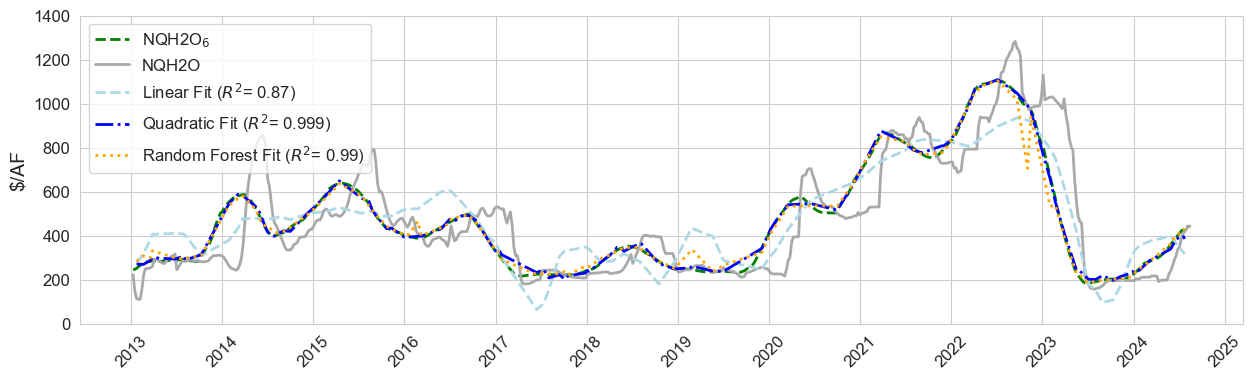

['linear_reg.pkl']

In [ ]:
# this cell is not being used for prediction, but for visualization purposes/method exploration

scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # keep 95% of variance
X_train_val_selected = pca.fit_transform(X_train_val, y_train_val)
X_test_selected = pca.transform(X_test)
scorer = make_scorer(r2_score)


linear_reg = LinearRegression()
y_pred_linear_train = cross_val_predict(linear_reg, X_train_val_selected, y_train_val, cv=3)
linear_reg.fit(X_train_val_selected, y_train_val)
y_pred_linear_test = linear_reg.predict(X_test_selected)


polynomial_reg_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])
polynomial_reg_grid = {'poly__degree': [2, 3, 4]}
polynomial_reg_cv = GridSearchCV(estimator=polynomial_reg_pipeline, param_grid=polynomial_reg_grid, scoring=scorer, cv=3)
polynomial_reg_cv.fit(X_train_val_selected, y_train_val)
y_pred_poly_train = polynomial_reg_cv.predict(X_train_val_selected)
y_pred_poly_test = polynomial_reg_cv.predict(X_test_selected)

random_forest = RandomForestRegressor(random_state=42)
random_forest_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
random_forest_cv = GridSearchCV(estimator=random_forest, param_grid=random_forest_grid, scoring=scorer, cv=3)
random_forest_cv.fit(X_train_val_selected, y_train_val)
y_pred_rf_train = random_forest_cv.predict(X_train_val_selected)
y_pred_rf_test = random_forest_cv.predict(X_test_selected)

# Best model from Linear Regression
# best_linear_reg = linear_reg_cv.best_estimator_
best_polynomial_reg = polynomial_reg_cv.best_estimator_
best_random_forest = random_forest_cv.best_estimator_

linear_reg_train_r2 = r2_score(y_train_val, y_pred_linear_train)
polynomial_reg_train_r2 = r2_score(y_train_val, best_polynomial_reg.predict(X_train_val_selected))
random_forest_train_r2 = r2_score(y_train_val, best_random_forest.predict(X_train_val_selected))

linear_reg_test_r2 = r2_score(y_test, y_pred_linear_test)
polynomial_reg_test_r2 = r2_score(y_test, best_polynomial_reg.predict(X_test_selected))
random_forest_test_r2 = r2_score(y_test, best_random_forest.predict(X_test_selected))

print(f"Linear Regression Train R^2: {linear_reg_train_r2}")
print(f"Linear Regression Test R^2: {linear_reg_test_r2}")

print(f"Polynomial Regression Train R^2: {polynomial_reg_train_r2}")
print(f"Polynomial Regression Test R^2: {polynomial_reg_test_r2}")

print(f"Random Forest Train R^2: {random_forest_train_r2}")
print(f"Random Forest Test R^2: {random_forest_test_r2}")

# predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_poly_test,
    'predicted_rf': y_pred_rf_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 9. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label='Linear Fit ($R^{2}$= 0.87)', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label='Quadratic Fit ($R^{2}$= 0.999)', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label='Random Forest Fit ($R^{2}$= 0.99)', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.show()

# joblib.dump(scaler, 'scaler.pkl')
# joblib.dump(pca, 'pca.pkl')
# joblib.dump(linear_reg, 'linear_reg.pkl')

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
# pd.set_option('display.max_rows', None)

# Step 1: Fit the Lasso model on the full dataset to determine the top features --> prediction results not good, as Lasso tend to relies heavily on a few features
# Lasso is feature dominant, so it is not a good model to use for prediction
# full_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
# full_pipeline.fit(X_train_val, y_train_val)
# y_pred = full_pipeline.predict(X_test)

full_pipeline = make_pipeline(StandardScaler(), ElasticNetCV(cv=3, l1_ratio=0.5, random_state=42))
full_pipeline.fit(X_train_val, y_train_val)
y_pred = full_pipeline.predict(X_test)


r2 = r2_score(y_test, y_pred)
print(f'R² score on the test set with all features: {r2:.2f}')

full_lasso_coef = full_pipeline.named_steps['elasticnetcv'].coef_
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': full_lasso_coef
})

coefficients['Rank'] = coefficients['Coefficient'].abs().rank(ascending=False)
coefficients = coefficients.sort_values(by='Rank')

# Step 2: Select the top 20 or 100 features
top_features = coefficients.head(100)
top_feature_names = top_features['Feature'].tolist()
print(top_features)

# Step 3: Retrain the Lasso model using only the top features
X_top_20 = X[top_feature_names]

X_train_val_top_20, X_test_top_20, y_train_val, y_test, train_date, test_date = train_test_split(
    X_top_20, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42
)

# top_20_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
top_20_pipeline = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=0.5, random_state=42))
top_20_pipeline.fit(X_train_val_top_20, y_train_val)

y_pred_top_20 = top_20_pipeline.predict(X_test_top_20)

r2_top_20 = r2_score(y_test, y_pred_top_20)
print(f'R² score on the test set with top 20 features: {r2_top_20:.2f}')

joblib.dump(top_20_pipeline, 'lasso_pipeline_top_20.pkl')
joblib.dump(top_feature_names, 'top_features.pkl')

R² score on the test set with all features: 0.99
                                 Feature  Coefficient   Rank
65    sanluisfederal_reclaimed_carryover   -11.279535    1.0
529          semitropic_tableA_carryover    10.450436    2.0
390                 ID4_tableA_carryover   -10.133359    3.0
1259         tularelake_tableA_carryover     9.760324    4.0
393                     ID4_exchanged_GW     9.222633    5.0
882         kerntulare_friant2_carryover     8.316485    6.0
1707                         pioneer_BVA     8.302740    7.0
1471           otherswp_tableA_recharged     8.119053    8.0
1731                           b2800_BVA     7.906974    9.0
1197          fresnoid_friant2_carryover     7.491509   10.0
642             wheeler_tableA_carryover     7.389164   11.0
1151            tulare_friant2_carryover     7.155553   12.0
1730                           b2800_BDM     7.105947   13.0
1674   metropolitan_SOC_tableA_carryover    -7.082069   14.0
7                      shasta_downst

['top_features.pkl']

In [149]:
X_top_20.describe()

,sanluisfederal_reclaimed_carryover,kerntulare_friant2_carryover,shasta_days_til_full,ID4_exchanged_GW,berrenda_tableA_carryover,lowertule_friant1_projected,exeter_friant1_carryover,success_available_storage,isabella_available_storage,kern_carryover,...,fresnoid_friant2_carryover,kerndelta_kern_carryover,sanluisstate_S,kerndelta_pumping,westkern_pumping,lrd_POSO_flow,bakersfield_kern_flood_irrigation,success_days_til_full,exeter_friant2_turnback,kerndelta_friant1_flood_irrigation
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,...,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,114.605553,-0.102882,547.553713,3.698219,1.999111,25.145733,-0.076883,-267.454813,454.602425,18.725572,...,-2.302444,2.387740,460.595741,0.486957,0.057580,0.012362,0.000014,984.445675,0.004395,0.001521
std,34.484647,0.051032,386.896538,5.963776,1.219729,8.601603,0.274022,99.393039,266.558477,8.123017,...,1.297535,4.178304,375.418576,0.247260,0.000355,0.024060,0.000037,44.400341,0.015007,0.004912
min,45.425444,-0.231354,16.571812,0.000000,0.353113,5.303941,-0.985346,-441.929225,29.429229,7.577863,...,-6.097363,-1.785567,-1.075512,0.119635,0.057087,0.000000,0.000000,821.041415,0.000000,0.000000
25%,91.829762,-0.127055,129.148282,0.000000,1.240198,18.971616,-0.090342,-362.123289,260.637246,12.281039,...,-2.775727,-0.334296,74.914024,0.293697,0.057228,0.000000,0.000000,999.990000,0.000000,0.000000
50%,111.548552,-0.096865,516.801595,0.760869,1.647820,25.204363,-0.003375,-254.147875,415.834633,16.976207,...,-2.343238,-0.009176,369.259781,0.433593,0.057631,0.000000,0.000000,999.990000,0.000000,0.000000
75%,133.328803,-0.048472,980.634910,4.785987,2.406084,31.934400,0.000294,-171.461550,581.033643,23.952116,...,-0.873927,4.456187,834.420915,0.668992,0.057917,0.010336,0.000000,999.990000,0.000000,0.000000
max,181.419475,-0.048472,999.990000,24.876228,5.376361,42.032391,0.430038,-119.978714,1427.681104,41.686528,...,-0.873927,14.693148,1008.236761,1.083107,0.058094,0.100167,0.000128,999.990000,0.084474,0.023007


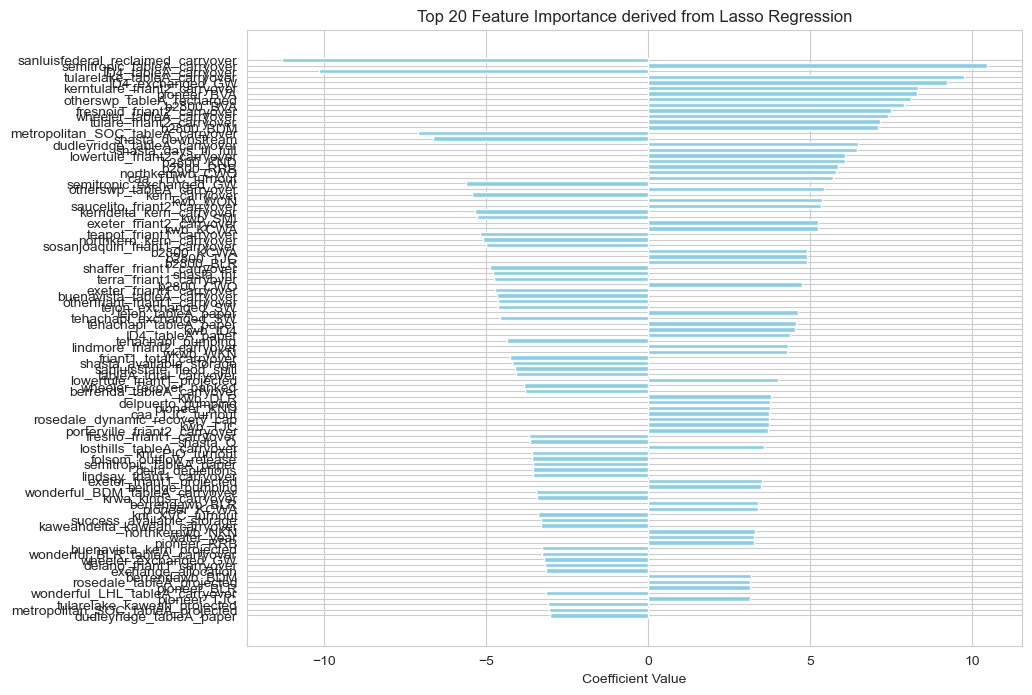

In [165]:
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Importance derived from Lasso Regression')
plt.gca().invert_yaxis()  # To have the highest rank at the top
plt.show()

In [166]:
def ensure_columns_match(df, reference_columns, fill_value='mean', fallback_value= 0):
    for col in reference_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    # Ensure columns match the reference list
    df = df[reference_columns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean() if not df[col].isna().all() else fallback_value
        df[col].fillna(mean_value, inplace=True)

    df[numeric_cols] = df[numeric_cols].clip(lower=np.finfo(np.float64).min, upper=np.finfo(np.float64).max, axis=1)
   
    return df

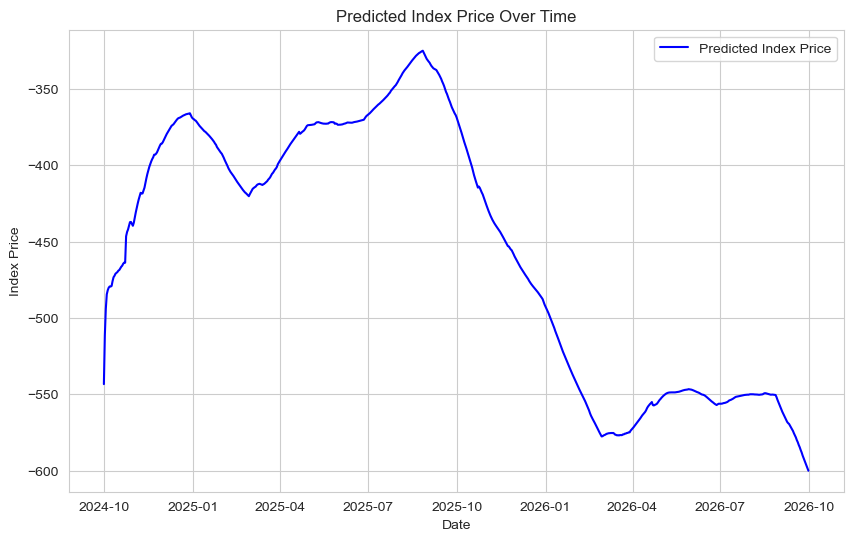

In [168]:
lasso_pipeline = joblib.load('lasso_pipeline_top_20.pkl')
top_features = joblib.load('top_features.pkl')

output_folder = "results/"
scenario_folder = os.path.join(output_folder, str(1))
output_file = os.path.join(scenario_folder, 'results.hdf5')


hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

window_size = '180D'
X = hydro_data.rolling(window=window_size, center=False).mean()
X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

X_top_20 = ensure_columns_match(X, top_features)
predicted_index_price = lasso_pipeline.predict(X_top_20)


plt.figure(figsize=(10, 6))
plt.plot(X.index, predicted_index_price, label='Predicted Index Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.title('Predicted Index Price Over Time')
plt.legend()
plt.show()

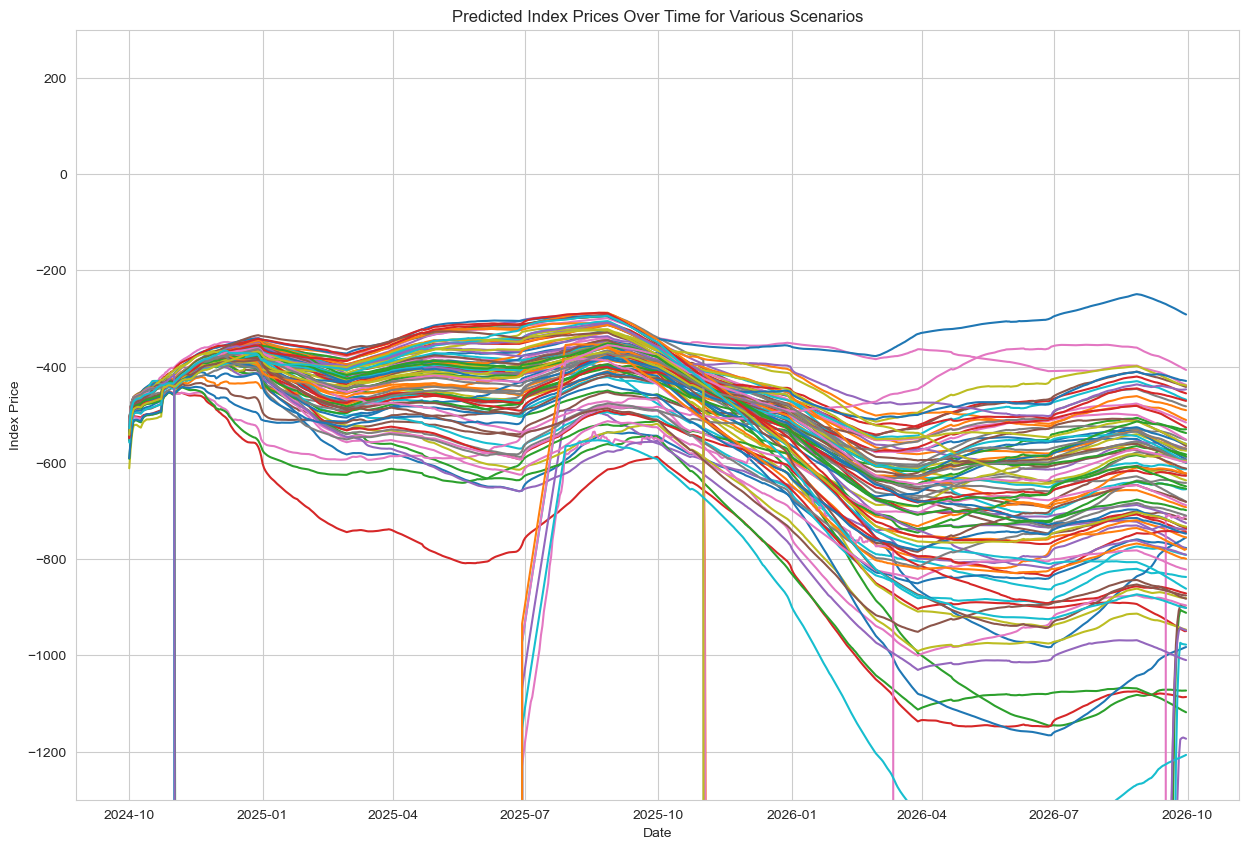

In [ ]:
lasso_pipeline = joblib.load('lasso_pipeline_top_20.pkl')
top_features = joblib.load('top_features.pkl')


output_folder = 'results/'

plt.figure(figsize=(15, 10))
all_predictions = []
for scenario_number in range(1, 101):
    scenario_folder = os.path.join(output_folder, str(scenario_number))
    output_file = os.path.join(scenario_folder, 'results.hdf5')

    hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

    # Calculate rolling mean
    window_size = '180D'
    X = hydro_data.rolling(window=window_size, center=False).mean()
    X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

    # Ensure feature columns match
    X_top_20 = ensure_columns_match(X, top_features)
    predicted_index_price = lasso_pipeline.predict(X_top_20)
    
    all_predictions.append(predicted_index_price)
    plt.plot(X.index, predicted_index_price, label=f'Scenario {scenario_number}')

# Finalize the main plot
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.ylim(-1300, 300)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)  # Adjust legend to avoid overlapping with the plot
plt.show()

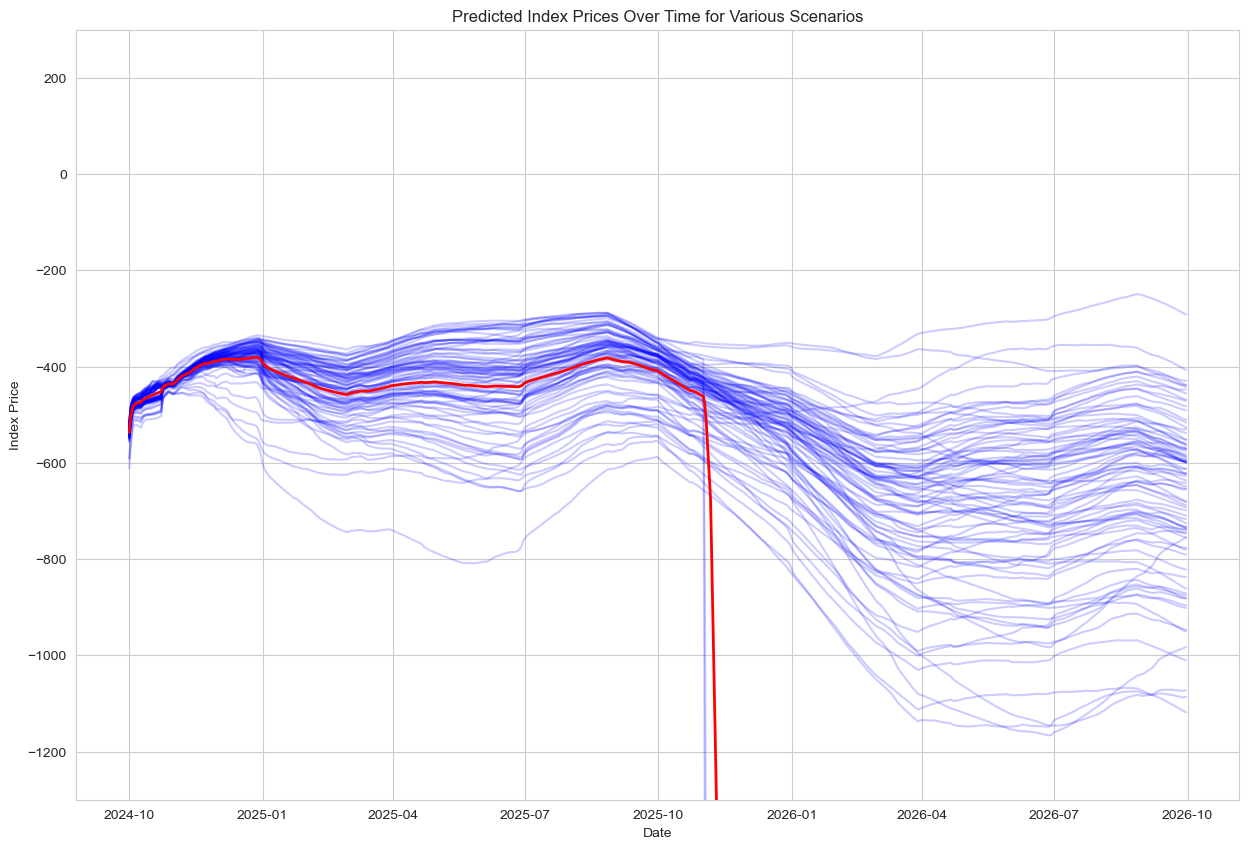

In [ ]:
from scipy.stats import zscore

all_predictions_array = np.array(all_predictions)

# Calculate the Z-scores of the predictions to identify the extremes
z_scores = np.abs(zscore(all_predictions_array, axis=0))

# Filter out extreme values where Z-score > threshold (here: 2 standard deviations)
threshold = 2
filtered_indices = np.where((z_scores < threshold).all(axis=1))[0]
filtered_predictions = all_predictions_array[filtered_indices]

# Calculate the average of the filtered predictions
average_prediction = np.mean(filtered_predictions, axis=0)

# Plot the filtered predictions and the average prediction
plt.figure(figsize=(15, 10))

for scenario_index in filtered_indices:
    plt.plot(X.index, all_predictions[scenario_index], label=f'Scenario {scenario_index + 1}', alpha=0.2, color='blue')

plt.plot(X.index, average_prediction, label='Average Prediction', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Index Price')
plt.ylim(-1300, 300)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
# plt.legend()
plt.show()

In [126]:
average_prediction_df = pd.DataFrame(average_prediction, columns=['Average_Prediction'])
average_prediction_df = average_prediction_df.round(2)
average_prediction_df.head(30)

,Average_Prediction
0,135.87
1,174.63
2,186.72
3,191.66
4,196.23
5,200.75
6,205.21
7,209.76
8,214.37
9,217.42
